In [1]:
import pandas as pd
from tqdm import tqdm

df = pd.read_excel("ERE.xlsx")

type_cols = [col for col in df.columns if '/qualifierId' in col]

# Precompute the endX and endY columns
df['endX'] = 0.0
df['endY'] = 0.0

# Create dictionaries to map from index to the correct qualifier columns
qualifier_value_cols = {int(col.split('/')[1]): col for col in df.columns if 'qualifier' in col and 'value' in col}

# Use tqdm to add a progress bar
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    for j, type_col in enumerate(type_cols):
        if row[type_col] == 140:
            endx_col = qualifier_value_cols[j]
            df.at[index, 'endX'] = row[endx_col]
        elif row[type_col] == 141:
            endy_col = qualifier_value_cols[j]
            df.at[index, 'endY'] = row[endy_col]

df.to_excel("Pass.xlsx")


Processing Rows: 100%|████████████████| 250227/250227 [01:12<00:00, 3428.59it/s]


In [2]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('Pass.xlsx')

# Filter dataframes as before
df_long_balls = df.loc[(df['typeId'] == 1) & (df['x'] < 30) & (df['endX'] > 50)]
df_deep_circulations = df.loc[(df['typeId'] == 1) & (df['x'] > 30) & (df['x'] < 60) & (df['y'] > 22) & (df['y'] < 78) & (df['endX'] > 30) & (df['endX'] < 60)]
df_wing_play = df.loc[(df['typeId'] == 1) & (df['x'] > 30) & (df['x'] < 60) & (df['y'] > 22) & (df['y'] < 78) & ((df['endY'] < 22) | (df['endY'] > 78))]
df_final_third = df.loc[(df['typeId'] == 1) & (df['x'] > 70)]
df_crossing = df.loc[
    (df['typeId'] == 1) & 
    (df['x'] > 50) & 
    ((df['y'] <= 22) | (df['y'] >= 78)) & 
    (df['endY'] >= 22) & 
    (df['endY'] <= 78) & 
    (df['endX'] > 85)
]
df_opposition_passes = df.loc[df['typeId'] == 1]
df_defensive_actions = df.loc[df['typeId'].isin([7, 8])]

# Count the total number of long balls for each contestantId
long_balls_count = df_long_balls.groupby('contestantId').size().reset_index(name='Long balls')

# Count the total number of deep circulations for each contestantId
deep_circulations_count = df_deep_circulations.groupby('contestantId').size().reset_index(name='Deep circulation')

# Count the total number of wing plays for each contestantId
wing_play_count = df_wing_play.groupby('contestantId').size().reset_index(name='Wing play')

# Count the total number of final third passes for each contestantId
final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')

# Count the total number of crossing passes for each contestantId
crossing_count = df_crossing.groupby('contestantId').size().reset_index(name='Crossing')

# Count the total number of opposition passes for each contestantId
opposition_passes_count = df_opposition_passes.groupby('contestantId').size().reset_index(name='Opposition passes')

# Count the total number of defensive actions for each contestantId
defensive_actions_count = df_defensive_actions.groupby('contestantId').size().reset_index(name='Defensive actions')

# Calculate the total number of final third passes across all contestants
total_final_third_passes = df_final_third.shape[0]

# Calculate the percentage of final third passes for each contestantId
final_third_count['Territory'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

# Create Low Block column
df['Low Block'] = df.apply(lambda row: 1 if row['typeId'] in [7, 8, 12] and row['x'] < 25 else 0, axis=1)

# Calculate total number of typeId 7, 8, 12 actions across the pitch
total_defensive_actions = df.loc[df['typeId'].isin([7, 8, 12])].shape[0]

# Calculate Low Block percentage per contestantId
low_block_count = df.groupby('contestantId')['Low Block'].sum().reset_index(name='Low Block')
low_block_count['Low Block'] = (low_block_count['Low Block'] / total_defensive_actions) * 100

# Add the new "Counters" column
def find_counters(df):
    counters = []
    for i in range(len(df)):
        if df.iloc[i]['typeId'] == 49 and df.iloc[i]['x'] < 50:
            found_counter = False
            for j in range(i + 1, min(i + 4, len(df))):
                if df.iloc[j]['typeId'] == 1 and df.iloc[j]['x'] > 70:
                    found_counter = True
                    break
            counters.append(1 if found_counter else 0)
        else:
            counters.append(0)
    return counters

# Apply the function to add the "Counters" column
df['Counters'] = find_counters(df)

# Aggregate "Counters" by contestantId
counters_count = df.groupby('contestantId')['Counters'].sum().reset_index(name='Counters')

# Merge the counts into a single dataframe
result = pd.merge(long_balls_count, deep_circulations_count, on='contestantId', how='outer').fillna(0)
result = pd.merge(result, wing_play_count, on='contestantId', how='outer').fillna(0)
result = pd.merge(result, final_third_count[['contestantId', 'Territory']], on='contestantId', how='outer').fillna(0)
result = pd.merge(result, crossing_count, on='contestantId', how='outer').fillna(0)
result = pd.merge(result, opposition_passes_count, on='contestantId', how='left').fillna(0)
result = pd.merge(result, defensive_actions_count, on='contestantId', how='left').fillna(0)

# Calculate High Press as the ratio of opposition passes from other contestants to defensive actions
# For each contestantId, compute the ratio of passes from other contestants divided by their defensive actions

# Compute total opposition passes by all contestants
total_opposition_passes = df_opposition_passes.groupby('contestantId').size().sum()

# Add a column to store the High Press ratio
result['High Press'] = result.apply(
    lambda row: (total_opposition_passes - row['Opposition passes']) / row['Defensive actions'] if row['Defensive actions'] > 0 else 0, 
    axis=1
)

# Merge the Low Block and Counters with the result DataFrame
result = pd.merge(result, low_block_count, on='contestantId', how='left').fillna(0)
result = pd.merge(result, counters_count, on='contestantId', how='left').fillna(0)

# Drop intermediate columns if not needed
result = result.drop(columns=['Opposition passes', 'Defensive actions'])

# Ensure the columns are integers where appropriate
result['Long balls'] = result['Long balls'].astype(int)
result['Deep circulation'] = result['Deep circulation'].astype(int)
result['Wing play'] = result['Wing play'].astype(int)
result['Crossing'] = result['Crossing'].astype(int)
result['High Press'] = result['High Press'].astype(float)  # Ensure High Press is float

# Save the final dataframe to a new Excel file
result.to_excel('Coach analysis/ERE - Coach.xlsx', index=False)


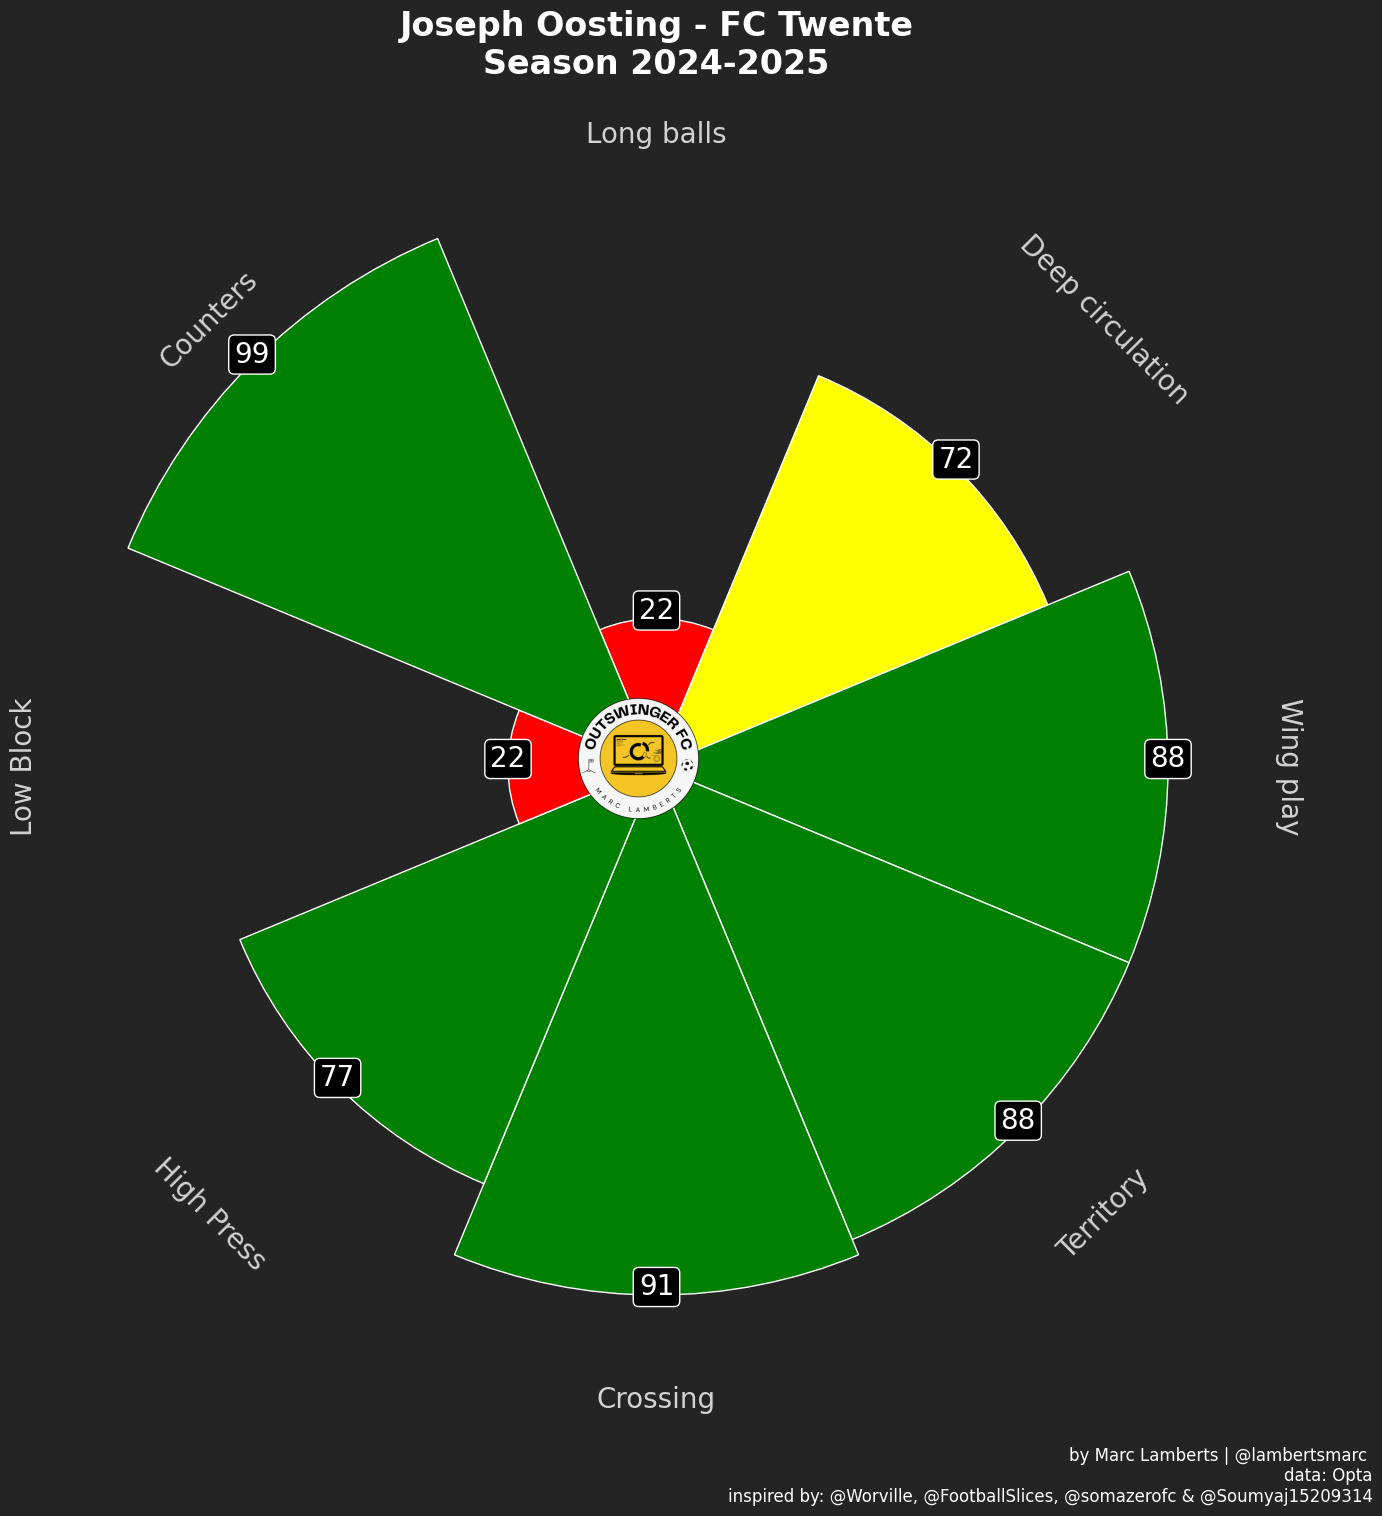

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import math
from mplsoccer import PyPizza, add_image
import matplotlib.pyplot as plt

# Load data from Excel file
df = pd.read_excel('/Users/marclambertes/Python/Coach analysis/ERE - Coach.xlsx')

# Ensure all columns except 'contestantId' are numerical
for col in df.columns:
    if col != 'contestantId':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a parameter list
params = df.columns[1:]  # Exclude 'contestantId'

# Select the player and get their data
player_name = 'FC Twente'  # Changed from the original ID to 'Ajax'
player_df = df[df['contestantId'] == '4tic29sox7m39fy1ztgv0jsiq'].reset_index(drop=True)  # Keep original ID for filtering
player = player_df.loc[0, params].tolist()

# Calculate percentile values
values = []
for param in params:
    param_series = df[param].dropna()
    player_value = player_df.loc[0, param]
    try:
        percentile = stats.percentileofscore(param_series, player_value)
        values.append(math.floor(percentile))
    except Exception as e:
        values.append(np.nan)

# Remove NaN values from the list of percentiles and ensure all values are integers
values = [0 if np.isnan(v) else int(v) for v in values]

# Ensure all values are within the range of 1 to 99
values = [max(1, min(99, v)) for v in values]

# Determine slice colors based on percentile ranges
slice_colors = []
for value in values:
    if value <= 25:
        slice_colors.append("#FF0000")  # Red
    elif 26 <= value <= 50:
        slice_colors.append("#FFA500")  # Orange
    elif 51 <= value <= 75:
        slice_colors.append("#FFFF00")  # Yellow
    else:
        slice_colors.append("#008000")  # Green

# Load logo image
logo_image = plt.imread('/Users/marclambertes/Downloads/Outswinger FC (3).png')

# Initialize PyPizza without any additional circles
baker = PyPizza(
    params=params,                  # list of parameters
    min_range=[0] * len(params),    # set minimum range as a list
    max_range=[100] * len(params),  # set maximum range as a list
    straight_line_color="white",    # color for straight lines
    straight_line_lw=0,             # hide the straight lines
    last_circle_lw=0,               # hide the outer circle
    other_circle_lw=0,              # hide the other inner circles
)

# Plot only the slices up to the percentile value
fig, ax = baker.make_pizza(
    values,              # list of values
    figsize=(15, 15),    # adjust figsize according to your need
    param_location=110,  # where the parameters will be added
    slice_colors=slice_colors,
    kwargs_slices=dict( 
        edgecolor="white",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="white", fontsize=20,
        va="center", alpha=.8
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="white", fontsize=20,
        zorder=3,
        bbox=dict(
            edgecolor="white", facecolor="#000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# Set a higher title with two lines of text
title = f'Joseph Oosting - {player_name}\nSeason 2024-2025'
plt.text(0.5, 1.1, title, color='white', fontsize=24, ha='center', transform=ax.transAxes, weight='bold')

# Add credits
notes = '@lambertsmarc'
CREDIT_1 = "by Marc Lamberts | @lambertsmarc \ndata: Opta"
CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

fig.text(
    0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=12,
    color="white",
    ha="right"
)

# Add the logo to the center of the pizza chart
# Coordinates (0, 0) place the image at the center of the chart
add_image(logo_image, fig, left=0.45, bottom=0.45, width=0.1, height=0.1)

# Set the background color of the figure and axis to match
fig.patch.set_facecolor('#242424')
ax.set_facecolor('#242424')

# Save the figure
plt.savefig(f'{player_name}.png', dpi=750, bbox_inches='tight', facecolor='#242424')


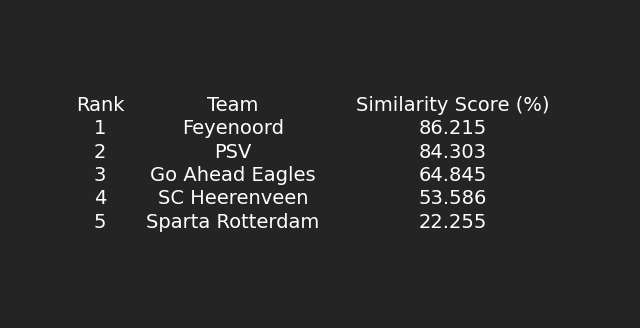

In [52]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table

# Step 1: Load the Excel File
file_path = 'Eredivisie - Coach.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Step 2: Preprocess the Data
team_names = df.iloc[:, 0]  # Extracting team IDs
data = df.iloc[:, 1:]  # Extracting numeric features

# Step 3: Create a mapping from team IDs to actual names
team_name_mapping = {
    "24fvcruwqrqvqa3aonf8c3zuy": "PSV",
    "20vymiy7bo8wkyxai3ew494fz": "Feyenoord",
    "b79uipsy57y1jqpy07h4i5ovk": "Go Ahead Eagles",
    "4vd2t5schmvvufrfib7f2vjdf": "SC Heerenveen",
    "89w5c6pw7vn0dxypi61tt0g4k": "Sparta Rotterdam"
}

# Step 4: Standardize the features (Z-scoring)
data_zscored = (data - data.mean()) / data.std()

# Step 5: Define a function to find the top 5 most similar teams
def find_top_5_similar_teams(input_team_name, data, team_names):
    # Check if the input team is in the list
    if input_team_name not in team_names.values:
        raise ValueError("Input team not found in the data.")
    
    # Get the vector for the input team
    input_team_vector = data[team_names == input_team_name].values
    
    # Calculate the cosine similarity
    similarity = cosine_similarity(input_team_vector, data)
    
    # Sort the similarity scores and get the indices of the top 5 most similar teams
    top_5_indices = np.argsort(similarity[0])[-6:-1][::-1]  # Get the top 5 excluding the input team itself
    
    # Get the names and scores of the top 5 most similar teams
    top_5_teams = team_names.iloc[top_5_indices].values
    top_5_scores = similarity[0][top_5_indices]
    
    # Map the team IDs to actual names
    top_5_teams_mapped = [team_name_mapping.get(team, team) for team in top_5_teams]
    
    # Convert scores to percentages with three decimal places
    top_5_scores_percentage = (top_5_scores * 100).round(3)
    
    # Create a DataFrame for the results with rank, team names, and similarity scores
    results_df = pd.DataFrame({
        'Rank': range(1, 6),  # Ranks from 1 to 5
        'Team': top_5_teams_mapped,
        'Similarity Score (%)': top_5_scores_percentage
    })
    
    return results_df

# Step 6: Use the function
input_team = "d0zdg647gvgc95xdtk1vpbkys"  # Replace with your input team ID (e.g., "24fvcruwqrqvqa3aonf8c3zuy" for PSV)
top_5_similar_teams_df = find_top_5_similar_teams(input_team, data_zscored, team_names)

# Step 7: Display the results in a styled table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjusted the figure size for better layout
ax.axis('off')  # Hide the axes

# Add table
tbl = table(ax, top_5_similar_teams_df, loc='center', cellLoc='center', colWidths=[0.1, 0.3, 0.2])

# Style the table
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(1.4, 1.4)  # Adjusted the scale for better padding
tbl.auto_set_column_width([0, 1, 2])

# Set background color and table styling
fig.patch.set_facecolor('#242424')  # Set background color for the entire figure

for (i, j), cell in tbl.get_celld().items():
    cell.set_text_props(color='white')  # Set text color to white
    cell.set_edgecolor('#242424')  # Set border color to match the background
    cell.set_linewidth(1.5)
    
    # Set the background color for header and data cells
    cell.set_facecolor('#242424')
    
    # Hide the row index by setting it to empty
    if j == -1:
        cell.set_text_props(text='')

# Save the table as a PNG file
plt.savefig('top_5_similar_teams.png', bbox_inches='tight', dpi=300, facecolor='#242424')  # Ensure background color is saved

plt.show()


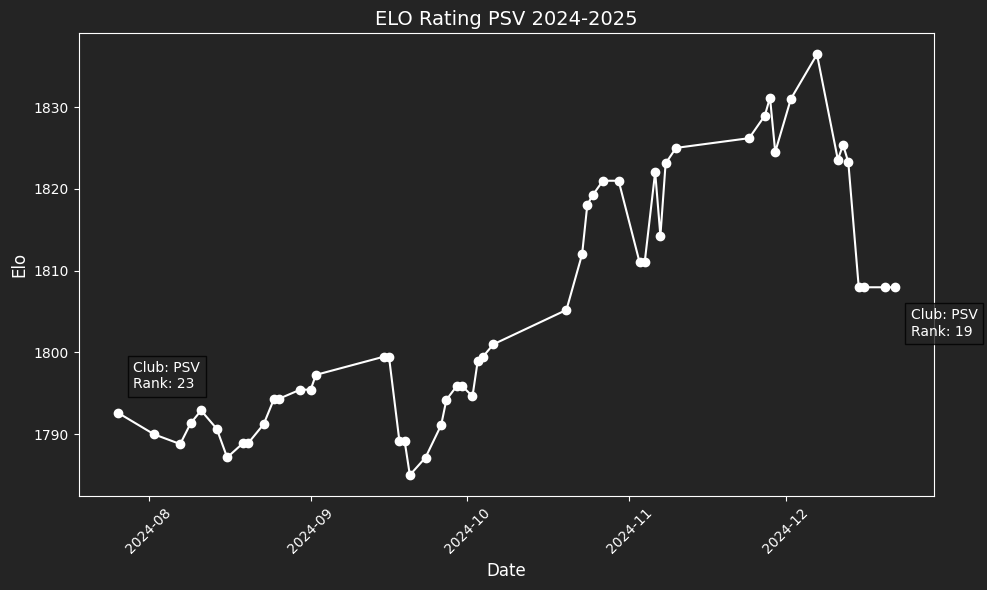

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the primary CSV file
file_path = '/Users/marclambertes/Downloads/DB2425/psv.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Convert date columns to datetime if needed
df['From'] = pd.to_datetime(df['From'])
df['To'] = pd.to_datetime(df['To'])

# Filter the data between the specified dates
mask = (df['From'] >= pd.to_datetime('2024-07-20')) & (df['To'] <= pd.to_datetime('2024-12-24'))
filtered_df = df.loc[mask]

# Load the additional CSV file for club and rank information
club_file_path = '/Users/marclambertes/Downloads/DB2425/2024-12-24.csv'  # Replace with your file path
club_df = pd.read_csv(club_file_path)

# Filter to find the row where the club is 'Ajax'
ajax_info = club_df[club_df['Club'] == 'PSV']

if not ajax_info.empty:
    # Set the ranks manually
    start_rank = 23  # Manually set the rank for the start point
    end_rank = 19   # Manually set the rank for the end point

    # Plot the graph
    plt.figure(figsize=(10, 6), facecolor='#242424')  # Set figure background color
    ax = plt.gca()  # Get current axis

    # Plot the data
    ax.plot(filtered_df['From'], filtered_df['Elo'], color='white', marker='o')

    # Customize the plot
    ax.set_facecolor('#242424')  # Set axes background color

    # Customize spines
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['top'].set_color('white')

    # Customize ticks and labels
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='both', colors='white')  # Set color for both x and y ticks
    plt.xticks(rotation=45, color='white')
    plt.yticks(color='white')

    # Update plot labels and title
    plt.xlabel('Date', fontsize=12, color='white')
    plt.ylabel('Elo', fontsize=12, color='white')
    plt.title('ELO Rating PSV 2024-2025', color='white', fontsize=14)

    # Calculate offsets for better annotation placement
    y_offset = (filtered_df['Elo'].max() - filtered_df['Elo'].min()) * 0.05  # 5% of the range
    x_offset = pd.Timedelta(days=3)  # Offset in days

    # Add text label for the starting point of the graph
    start_date = filtered_df['From'].iloc[0]
    start_elo = filtered_df['Elo'].iloc[0]
    start_label = f"Club: PSV\nRank: {start_rank}"

    # Add text label for the endpoint of the graph
    end_date = filtered_df['From'].iloc[-1]
    end_elo = filtered_df['Elo'].iloc[-1]
    end_label = f"Club: PSV\nRank: {end_rank}"

    # Adjust the text positions to avoid overlapping with data points
    ax.text(start_date + x_offset, start_elo + y_offset, start_label, color='white', fontsize=10, ha='left', va='bottom', bbox=dict(facecolor='#242424', alpha=0.8))
    ax.text(end_date + x_offset, end_elo - y_offset, end_label, color='white', fontsize=10, ha='left', va='top', bbox=dict(facecolor='#242424', alpha=0.8))

    # Remove the grid to keep it clean
    plt.grid(False)

    # Adjust layout to ensure everything fits well
    plt.tight_layout()

    # Save the plot to a PNG file
    output_path = '/Users/marclambertes/Downloads/elo_psv.png'  # Replace with your desired output path
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')  # Save with high resolution

    # Display the plot
    plt.show()
else:
    print("No data found for club Ajax.")


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96805921 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


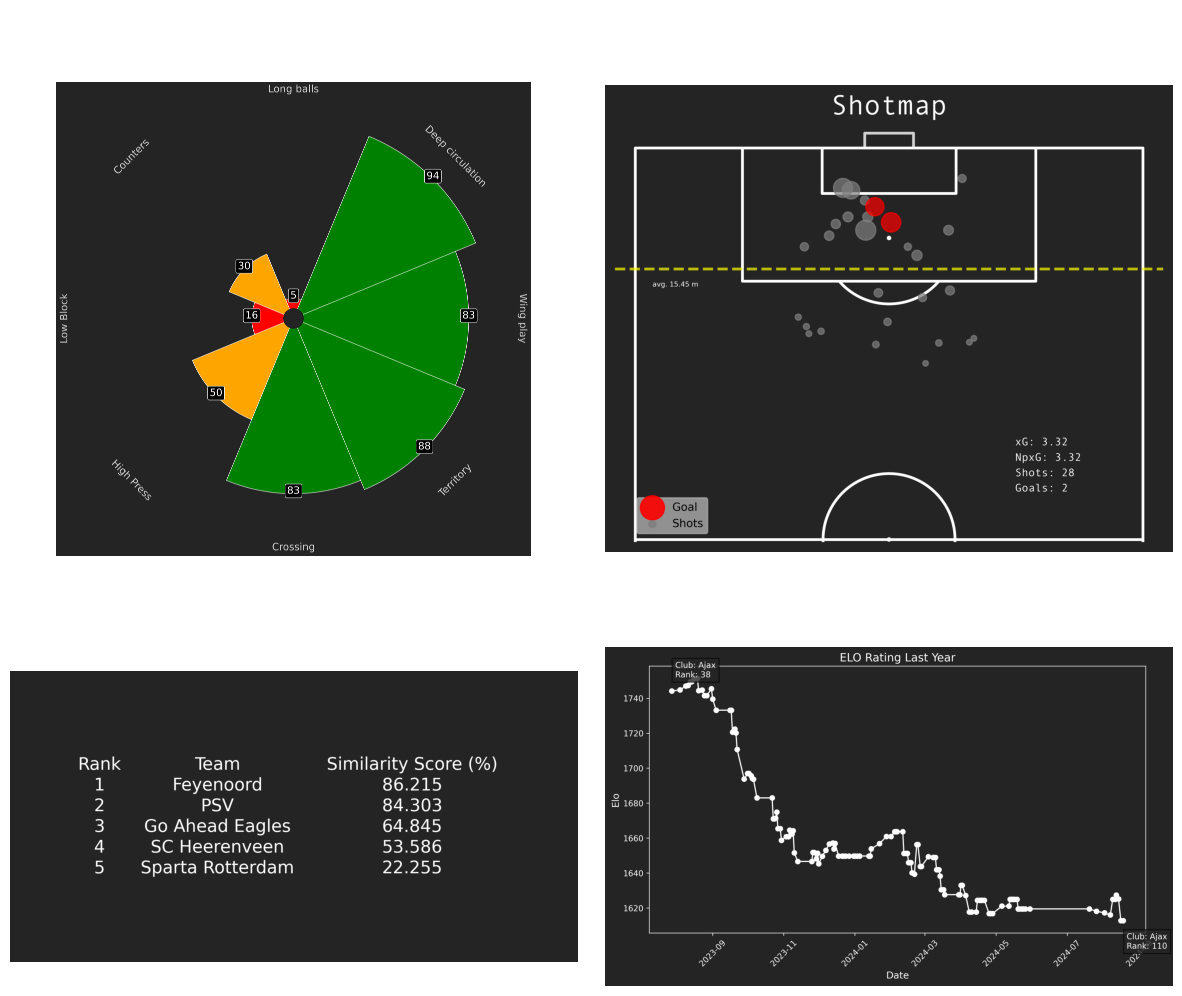

In [72]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the PNG images
image1 = Image.open('Ajax.png')
image2 = Image.open('shotmap.png')
image3 = Image.open('top_5_similar_teams.png')
image4 = Image.open('/Users/marclambertes/Downloads/elo_rating_last_year.png')



# Create a figure with nine subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Remove axis labels and ticks
for row in axes:
    for ax in row:
        ax.axis('off')

# Plot the images
axes[0, 0].imshow(image1)
axes[1, 0].imshow(image3)


axes[0, 1].imshow(image2)
axes[1, 1].imshow(image4)





# Add a title to the plot
fig.suptitle("Farioli's Ajax", fontsize=30, color='white')

# Adjust the layout and spacing
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.92)

# Save the plot to a file
plt.savefig('Subplots.png', dpi=300, bbox_inches='tight', facecolor='#242424')

# Display the plot
plt.show()
